# Analysis Expectation

A machine learning model is requested to be developed that can predict whether individuals have diabetes or not when their features are specified.

# Story of the Dataset

The dataset is a subset of a large dataset maintained by the National Institute of Diabetes, Digestive, and Kidney Diseases in the United States. It is utilized for a diabetes research study conducted on Pima Indian women, aged 21 and above, residing in Phoenix, which is the fifth-largest city in the state of Arizona. The target variable is defined as "outcome," indicating that 1 represents a positive outcome in the diabetes test, while 0 represents a negative outcome.
    
- **Pregnancies:** Number of pregnancies
- **Glucose:** Plasma glucose concentration after 2 hours in an oral glucose tolerance test
- **Blood Pressure:** Blood Pressure (Diastolic) (mm Hg)
- **SkinThickness:** Skin Thickness
- **Insulin:** Serum insulin level after 2 hours (mu U/ml)
- **DiabetesPedigreeFunction:** Diabetes pedigree function (a function related to the diabetes history in family)
- **BMI:** Body Mass Index
- **Age:** Age (years)
- **Outcome:** Whether the individual has the disease (1) or not (0)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df = pd.read_csv('diabetes.csv')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [36]:
def analyze_df(dataframe):
    
    print(f"Shape: {dataframe.shape}")
    print("------------------------------ Head ------------------------------")
    print(dataframe.head())
    print("------------------------------ Tail ------------------------------")
    print(dataframe.tail())
    print("------------------------------ Types ------------------------------")
    print(dataframe.dtypes)
    print("------------------------------ Unique Values -----------------------------")
    print(dataframe.nunique())
    print("------------------------------ Null Values -----------------------------")
    print(dataframe.isnull().sum())
    print("------------------------------ Quantiles ------------------------------")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

analyze_df(df)

Shape: (768, 9)
------------------------------ Head ------------------------------
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
------------------------------ Tail ------------------------------
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
763           10      101             76             48      180 32.900 

In [37]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    """
    Provides the names of categorical, numeric, and categorical-like but cardinal variables in the dataset.
    Note: Numeric-looking categorical variables are also included in categorical variables.

    Parameters
    ------
    dataframe: dataframe
            DataFrame from which variable names are to be extracted.
    cat_th: int, optional
            Class threshold value for numeric but categorical variables.
    car_th: int, optional
            Class threshold value for categorical but cardinal variables.

    Returns
    ------
        cat_cols: list
                List of categorical variable names.
        num_cols: list
                List of numeric variable names.
        cat_but_car: list
                List of categorical-like but cardinal variable names.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
        

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables.
        num_but_cat is within cat_cols.
    """
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [38]:
print({"cat_cols": cat_cols,
       "num_cols": num_cols,
       "cat_but_car": cat_but_car})

{'cat_cols': ['Outcome'], 'num_cols': ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], 'cat_but_car': []}


   Outcome  Ratio
0      500 65.104
1      268 34.896


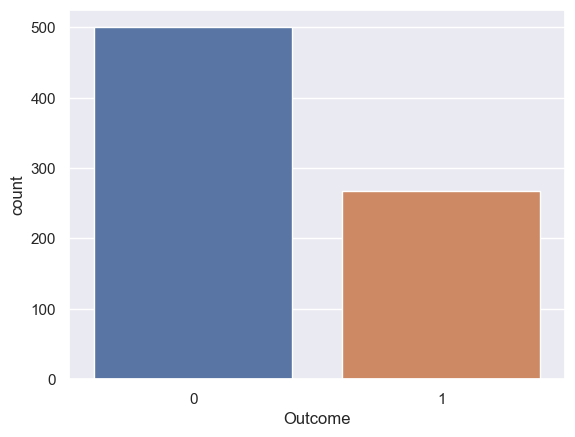

In [39]:
def cat_summary(dataframe, column, plot=True):
    
    print(pd.DataFrame({column: dataframe[column].value_counts(), "Ratio": 100 * dataframe[column].value_counts() / len(dataframe)}))
    
    if plot:
        
        sns.countplot(x=dataframe[column], data=dataframe)
        plt.show()

cat_summary(df, "Outcome")

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


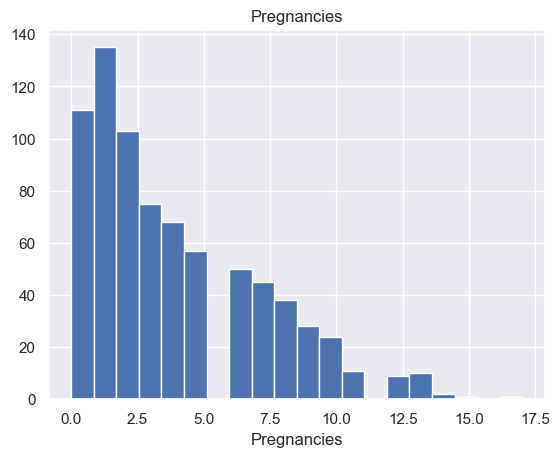

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


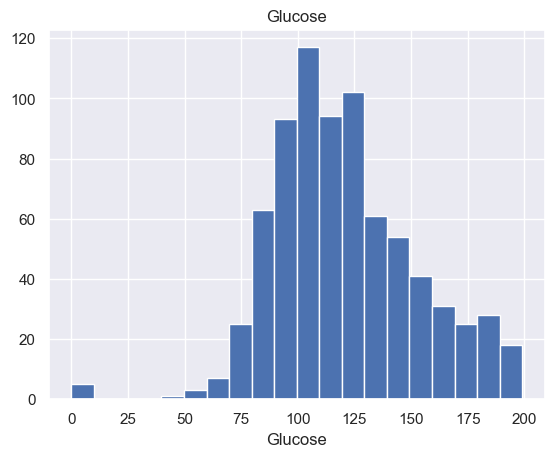

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


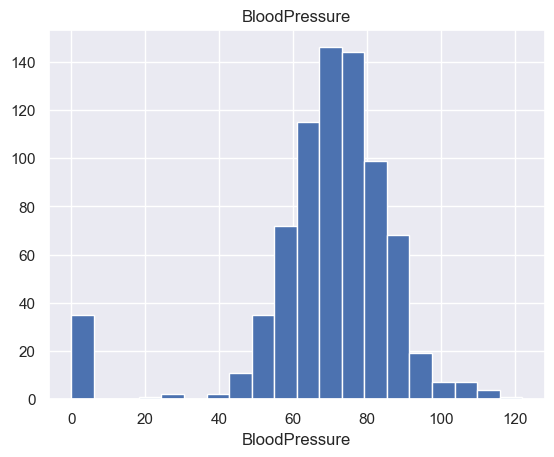

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


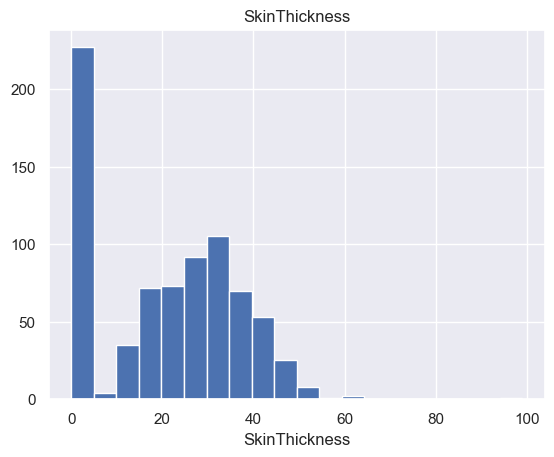

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


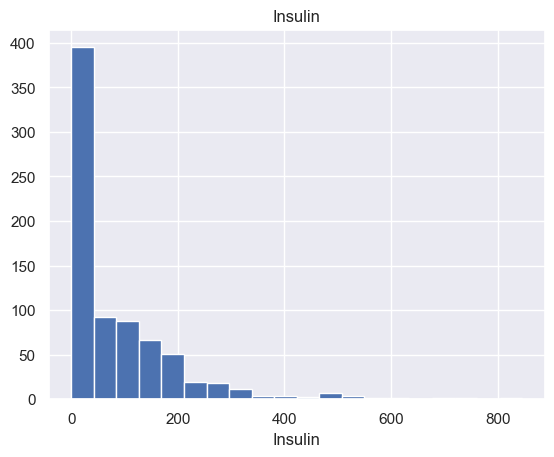

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


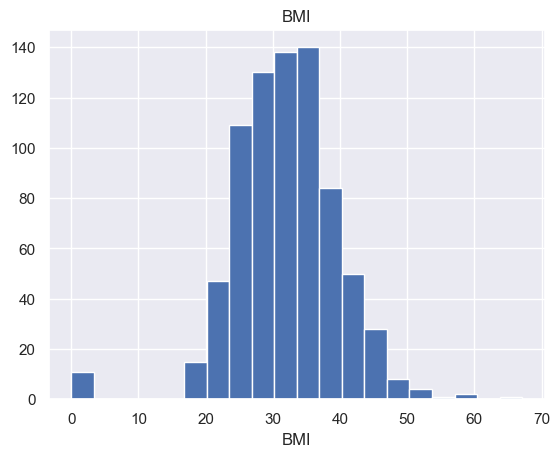

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


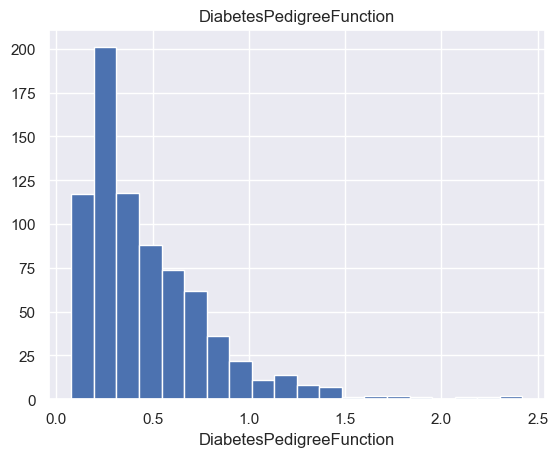

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


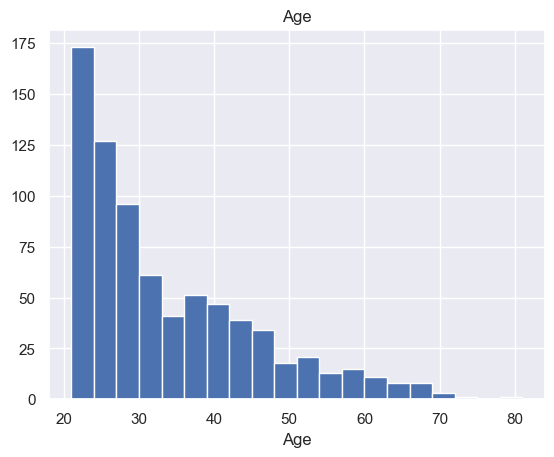

In [40]:
def num_summary(dataframe, numerical_col, plot=True):
    
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col)

In [41]:
def target_summary_with_num(dataframe, target, numerical_col):
    
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




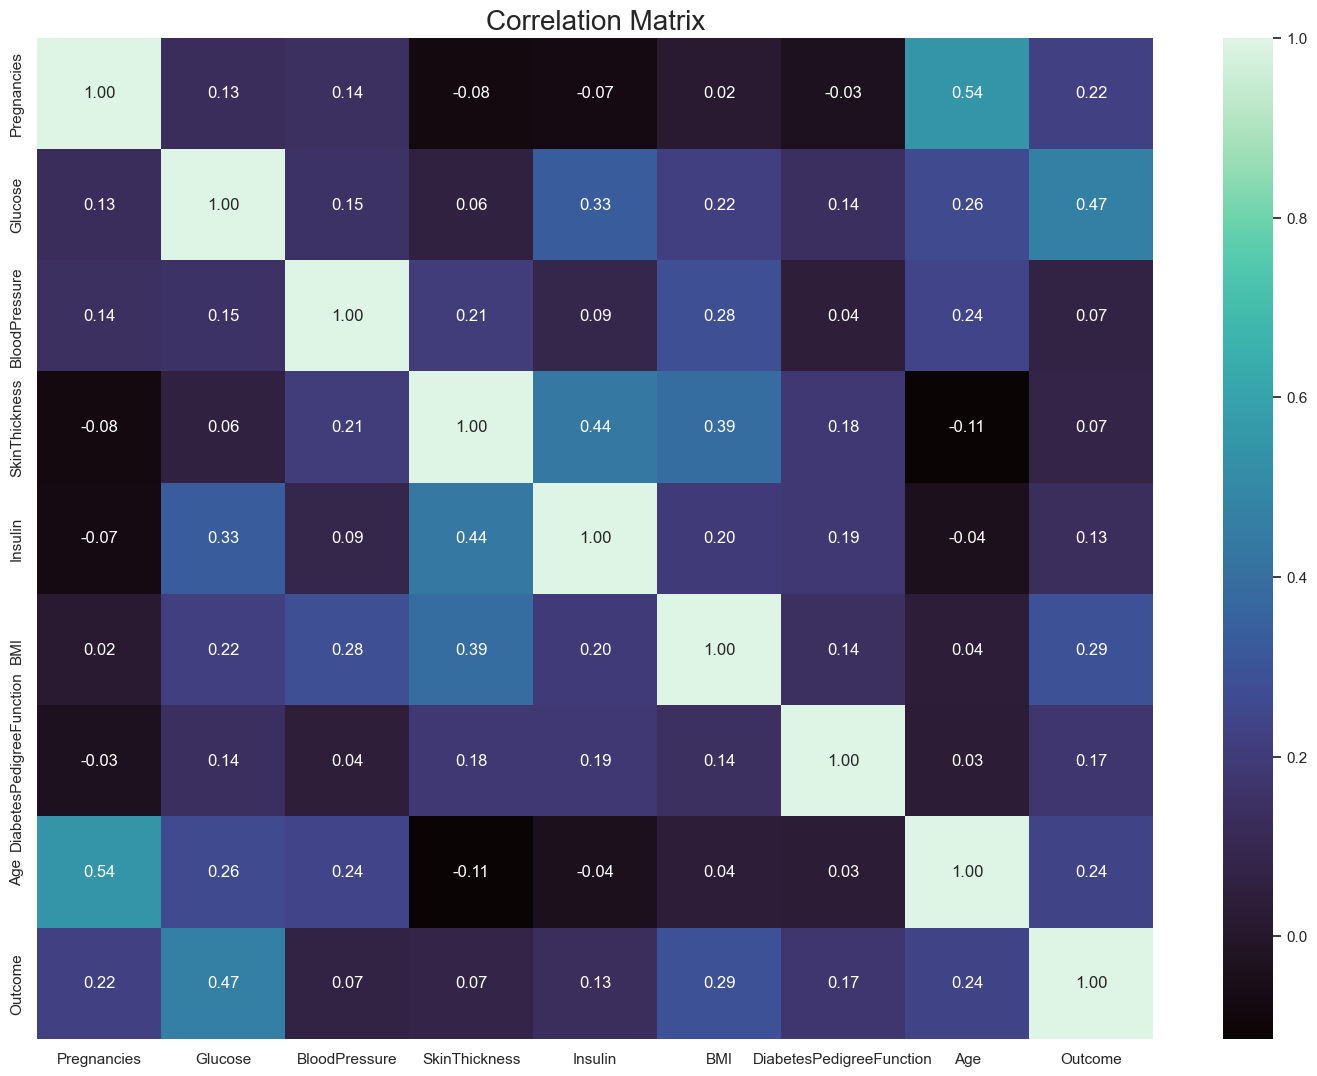

In [42]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="mako")
ax.set_title("Correlation Matrix", fontsize=20)

plt.show(block=True)

In [43]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.75
Recall: 0.663
Precision: 0.56
F1: 0.61
Auc: 0.72


   Value                   Feature
1  0.256                   Glucose
5  0.145                       BMI
7  0.139                       Age
6  0.127  DiabetesPedigreeFunction
0  0.105               Pregnancies
2  0.086             BloodPressure
4  0.074                   Insulin
3  0.068             SkinThickness


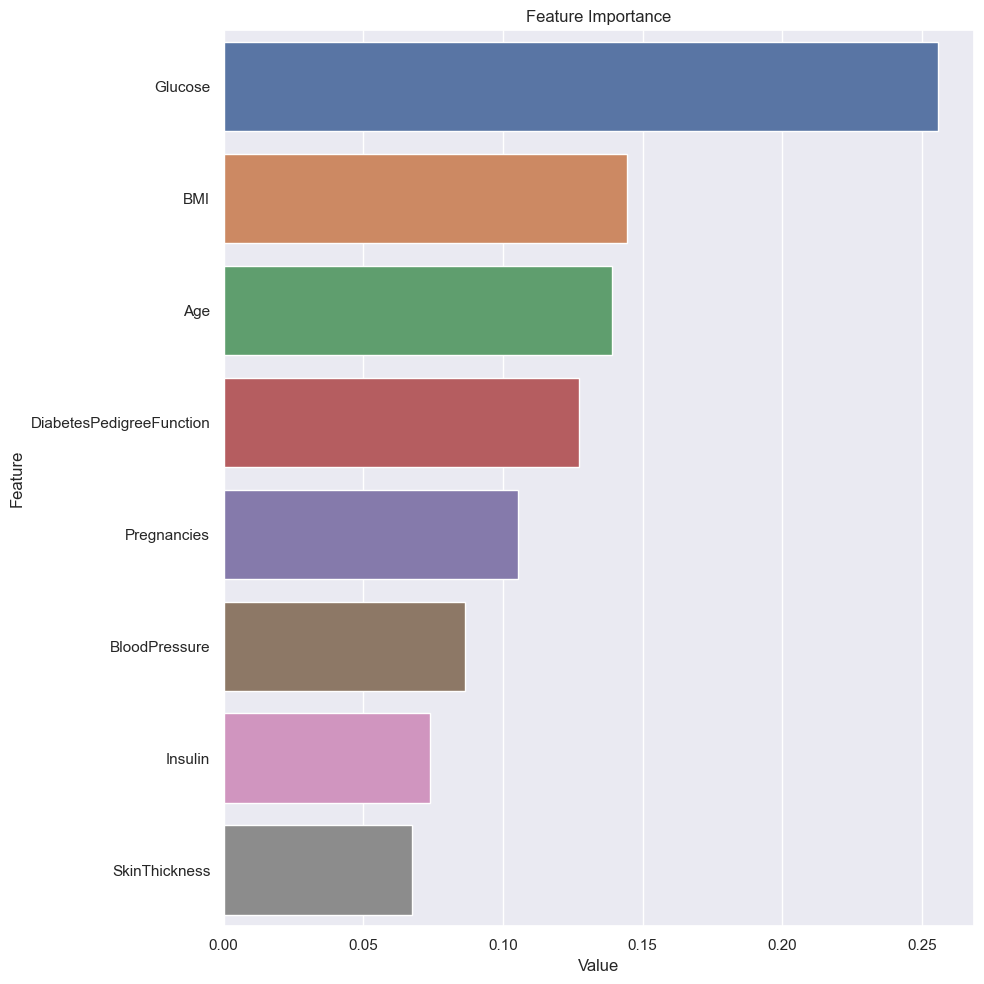

In [44]:
def plot_importance(model, features, num=len(X)):
    
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show(block=True)

plot_importance(rf_model, X)

In [45]:
zero_cols = [col for col in df.columns if (df[col].min() == 0 and col not in ["Outcome", "Pregnancies"])]
zero_cols

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [46]:
for col in zero_cols:
    df[col] = np.where(df[col] == 0, np.nan, df[col])
    
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [47]:
(df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)

Insulin                    48.698
SkinThickness              29.557
BloodPressure               4.557
BMI                         1.432
Glucose                     0.651
Pregnancies                 0.000
DiabetesPedigreeFunction    0.000
Age                         0.000
Outcome                     0.000
dtype: float64

In [48]:
def missing_values(dataframe, na_name=False):
    
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_missing = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_missing, np.round(ratio, 2)], axis=1, keys=['n_missing', 'ratio'])
    print(missing_df)
    
    if na_name:
        
        return na_columns
    
na_columns = missing_values(df, na_name=True)

               n_missing  ratio
Insulin              374 48.700
SkinThickness        227 29.560
BloodPressure         35  4.560
BMI                   11  1.430
Glucose                5  0.650


In [49]:
def missing_vs_target(dataframe, target, na_columns):
    
    temp_df = dataframe.copy()
    
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
        na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




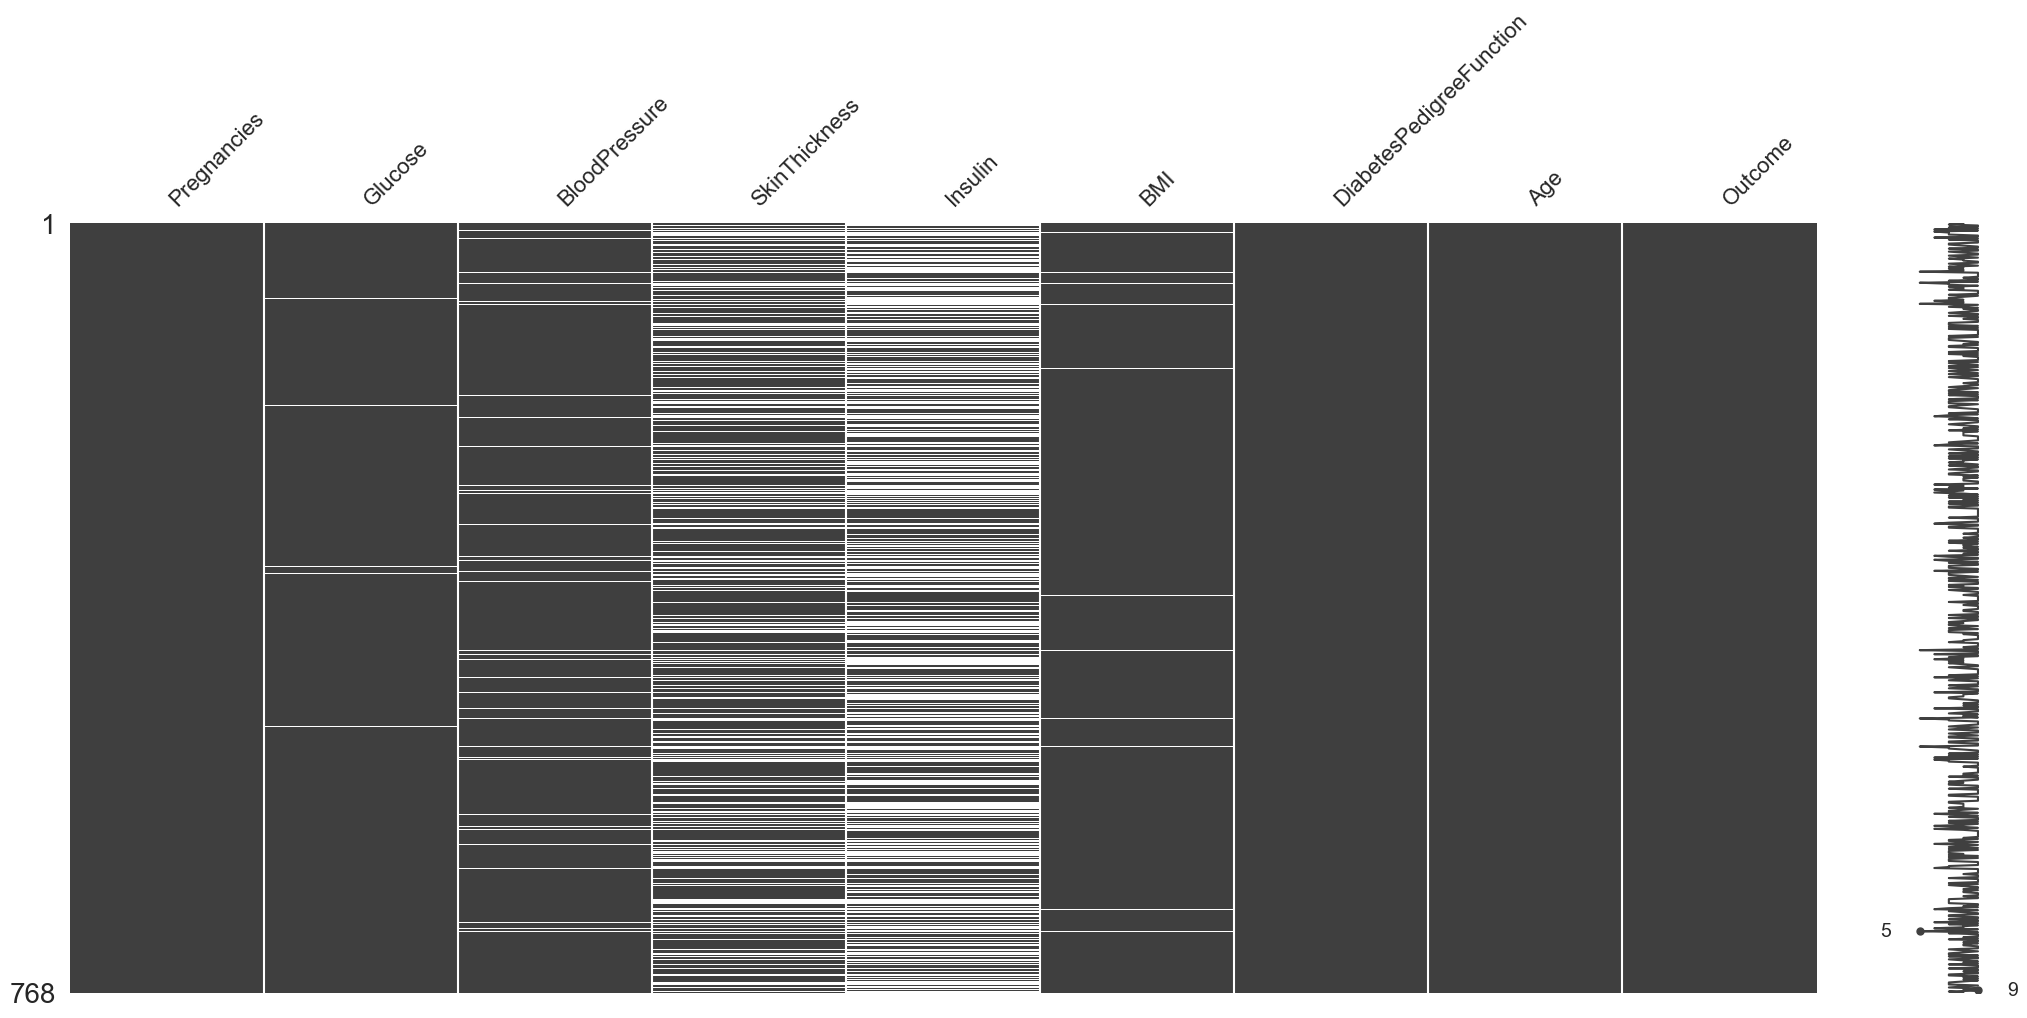

In [50]:
msno.matrix(df)
plt.show()

In [51]:
for col in zero_cols:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isnull().values.any()

False

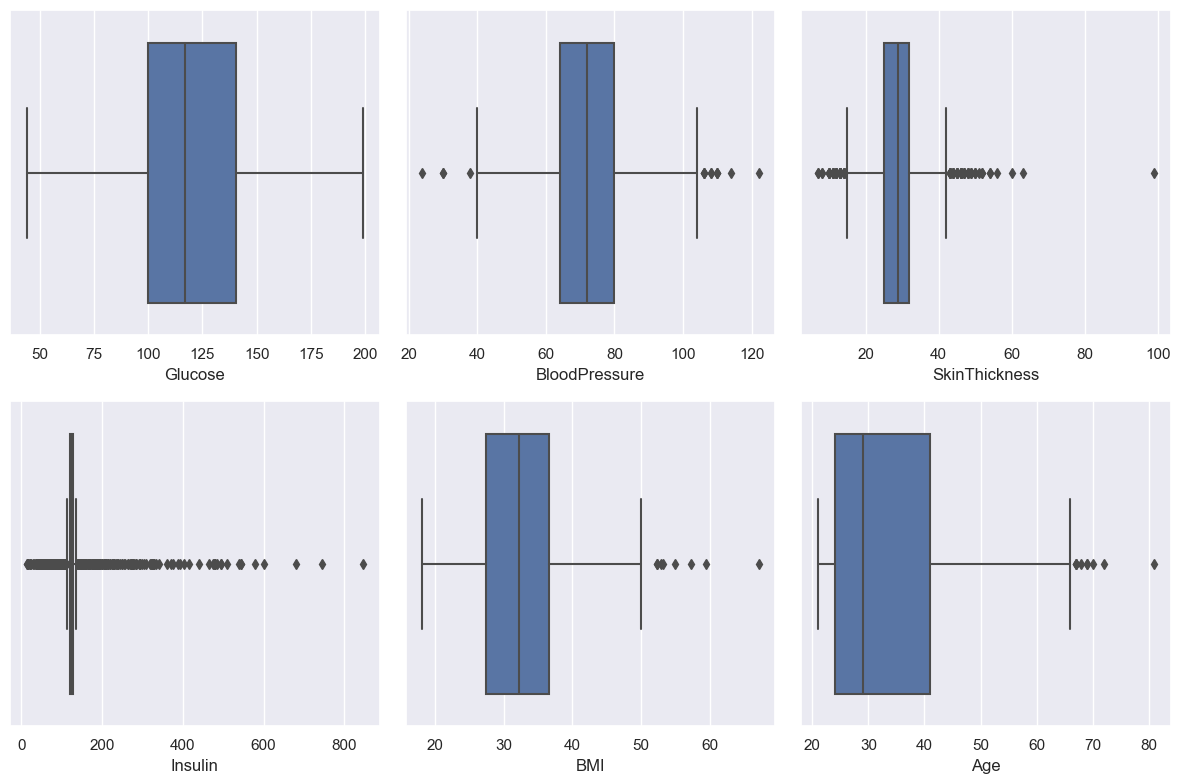

In [52]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
sns.boxplot(x=df["Glucose"])
plt.subplot(2, 3, 2)
sns.boxplot(x=df["BloodPressure"])
plt.subplot(2, 3, 3)
sns.boxplot(x=df["SkinThickness"])
plt.subplot(2, 3, 4)
sns.boxplot(x=df["Insulin"])
plt.subplot(2, 3, 5)
sns.boxplot(x=df["BMI"])
plt.subplot(2, 3, 6)
sns.boxplot(x=df["Age"])

plt.tight_layout()
plt.show()

In [53]:
def outlier_thresholds(dataframe, column, q1=0.05, q3=0.95):
    
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquantile_range = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interquantile_range
    up_limit = quartile3 + 1.5 * interquantile_range
    return low_limit, up_limit

for col in df.columns:
    print(col, outlier_thresholds(df, col))

Pregnancies (-15.0, 25.0)
Glucose (-71.5, 332.5)
BloodPressure (-5.0, 147.0)
SkinThickness (-30.124999999999993, 88.475)
Insulin (-314.5, 657.5)
BMI (-11.004999999999995, 77.63499999999999)
DiabetesPedigreeFunction (-1.3483999999999996, 2.621599999999999)
Age (-34.5, 113.5)
Outcome (-1.5, 2.5)


In [54]:
def check_outlier(dataframe, column):
    
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    
    if dataframe[(dataframe[column] < low_limit) | (dataframe[column] > up_limit)].any(axis=None):
        return True
    else:
        return False

In [55]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [56]:
for col in df.columns:
    print(col, check_outlier(df, col))
    
    if check_outlier(df, col):
        
        replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [57]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


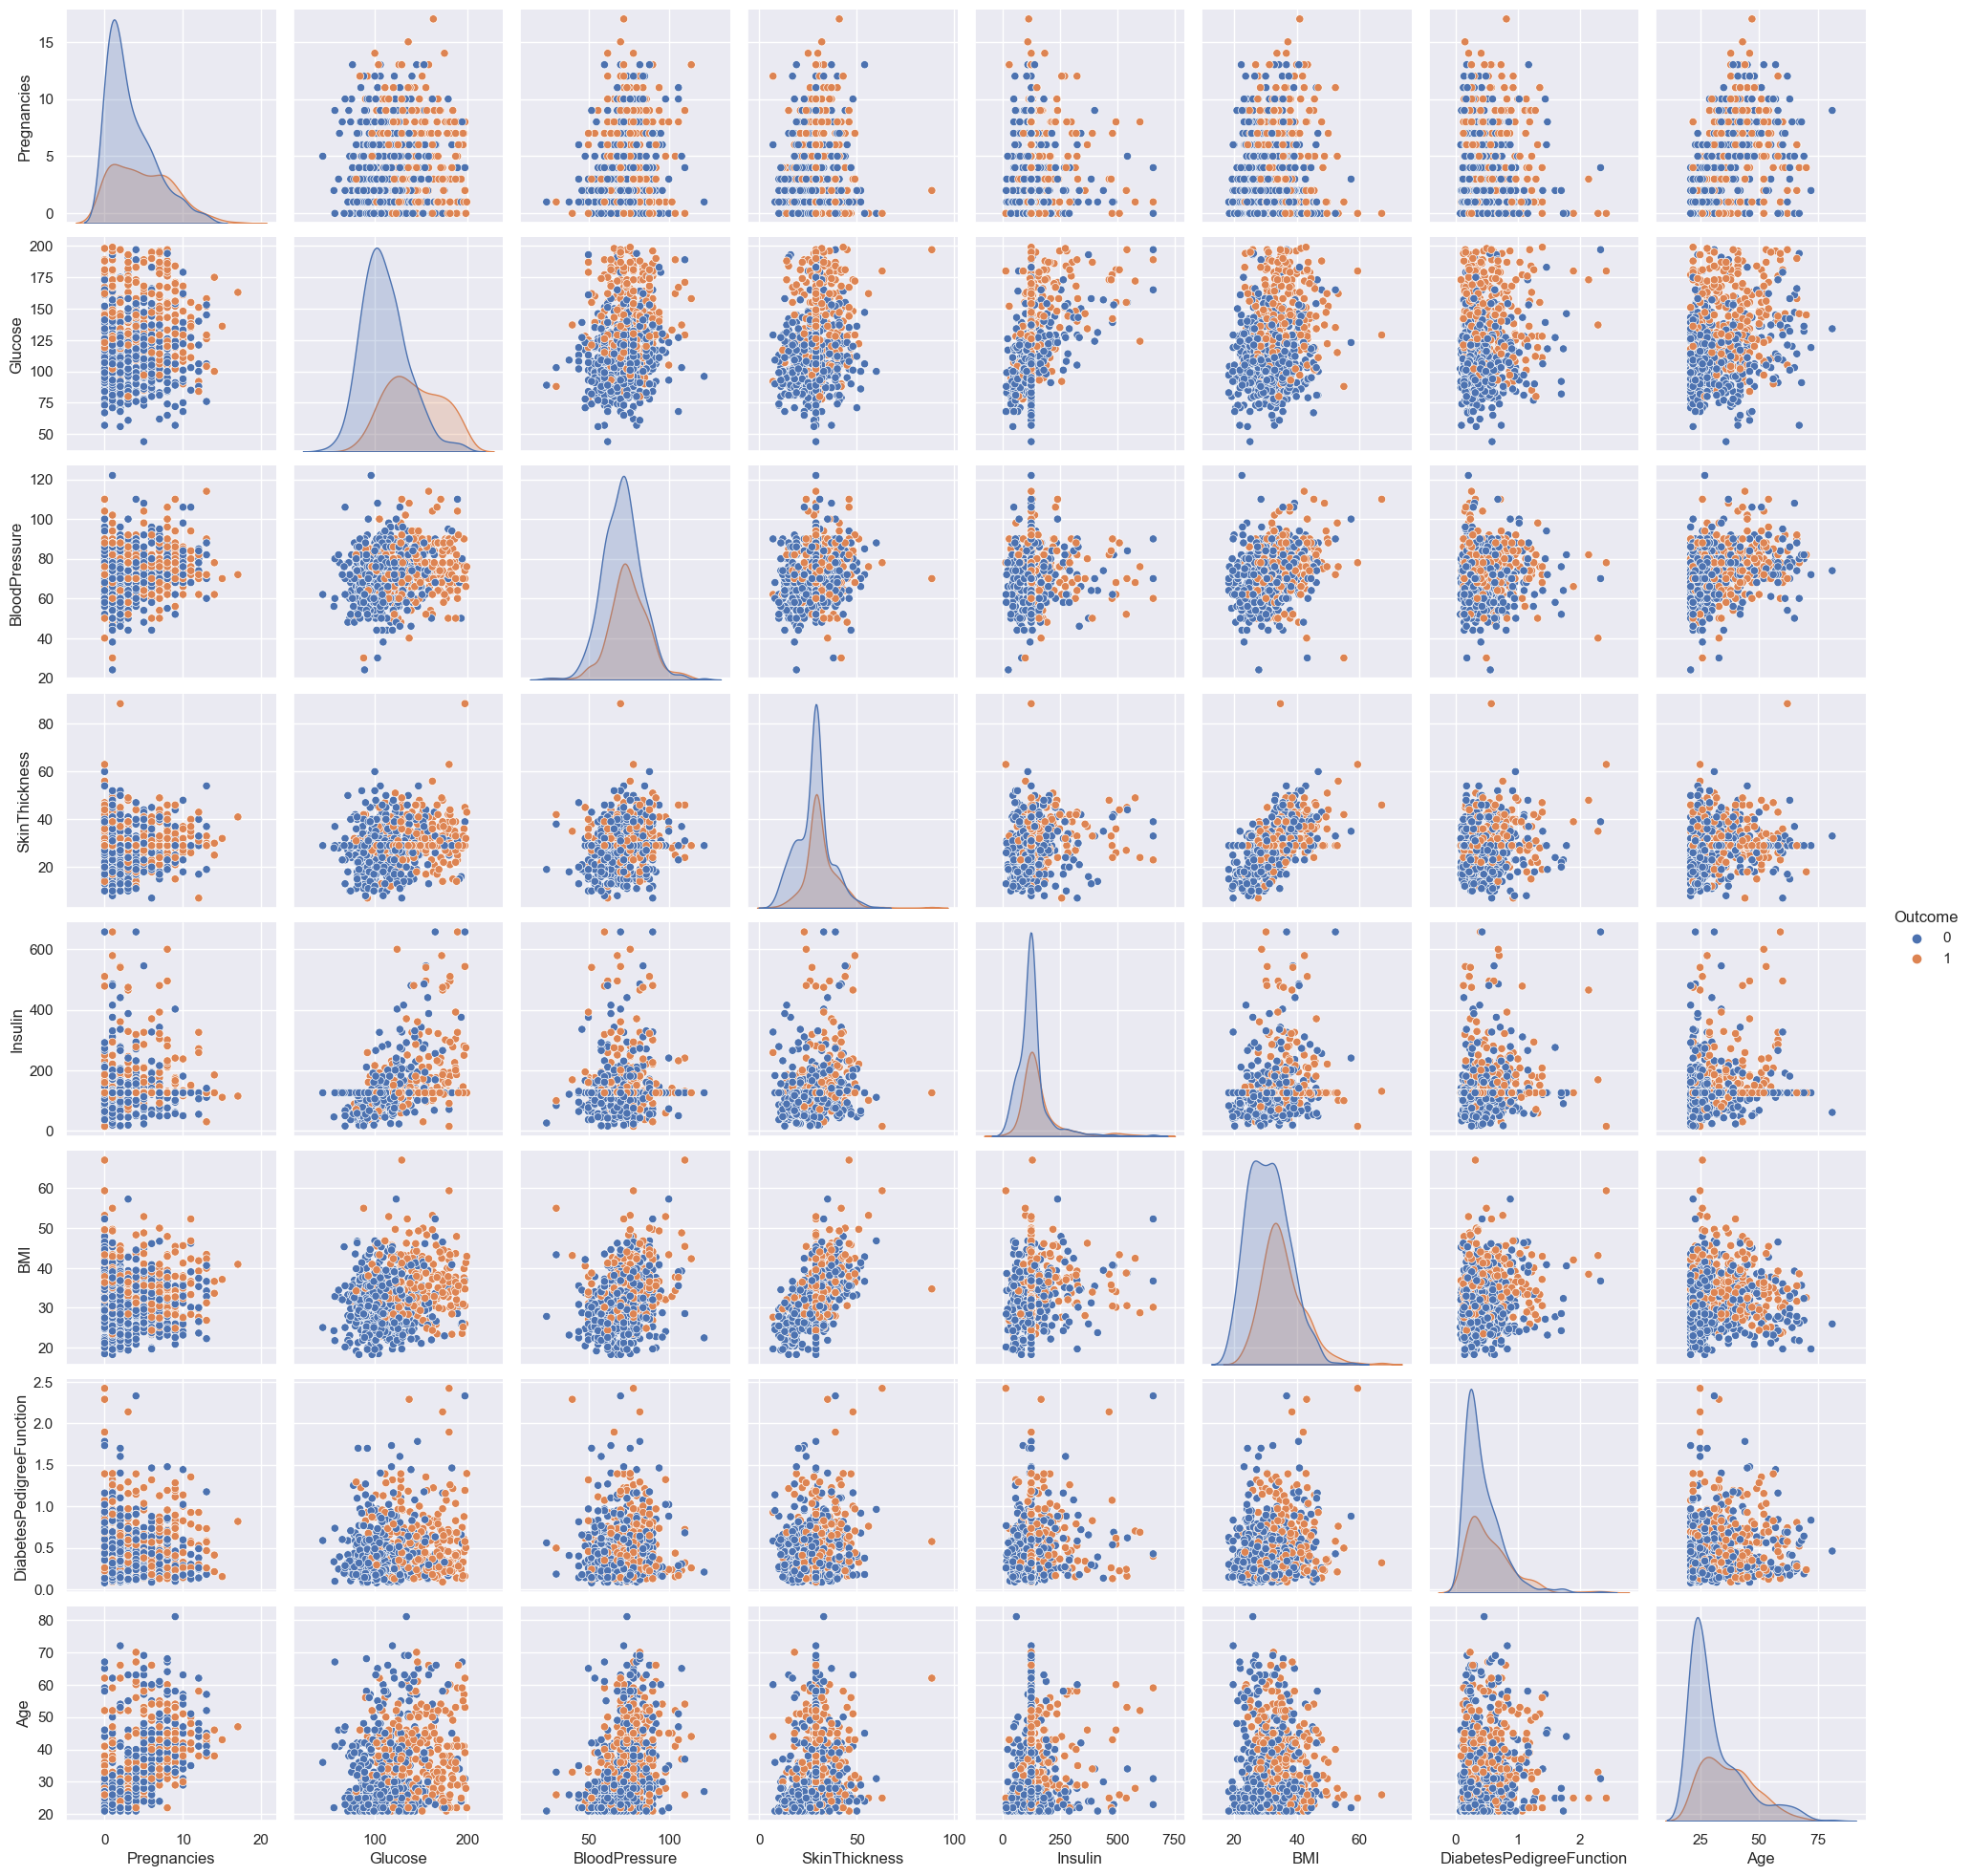

In [58]:
sns.set_style("darkgrid")
sns.pairplot(df, hue="Outcome")

In [59]:
df["CAT_GLUCOSE"] = pd.cut(x=df["Glucose"],
                           bins=[0, 100, 120, 145, 300],
                           labels=["Low", "Normal", "Prediabetes", "Diabetes"])

df['CAT_BMI'] = pd.cut(x=df['BMI'],
                       bins=[0, 18.5, 25, 30, 80],
                       labels=["Underweight", "Healthy", "Overweight", "Obese"])

df['CAT_AGE'] = pd.cut(x=df['Age'],
                       bins=[0, 18, 30, 50, 100],
                       labels=["Young", "Adult", "Mature", "Senior"])

df.loc[(df["Pregnancies"] > 0), "PREGNANCY"] = "1"
df.loc[(df["Pregnancies"] == 0), "PREGNANCY"] = "0"

df.loc[(df["Insulin"] > 80), "HIGH_INSULIN"] = "1"
df.loc[(df["Insulin"] < 80), "HIGH_INSULIN"] = "0"

df.columns = [col.upper() for col in df.columns]

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,CAT_GLUCOSE,CAT_BMI,CAT_AGE,PREGNANCY,HIGH_INSULIN
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Diabetes,Obese,Mature,1,1
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Low,Overweight,Mature,1,1
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Diabetes,Healthy,Mature,1,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Low,Overweight,Adult,1,1
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Prediabetes,Obese,Mature,0,1


In [60]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 14
cat_cols: 6
num_cols: 8
cat_but_car: 0
num_but_cat: 4


In [61]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['PREGNANCY', 'HIGH_INSULIN']

In [62]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [63]:
for col in binary_cols:
    df = label_encoder(df, col)

In [64]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['CAT_GLUCOSE', 'CAT_BMI', 'CAT_AGE']

In [65]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [66]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [68]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.78
Recall: 0.691
Precision: 0.63
F1: 0.66
Auc: 0.75


    Value                   Feature
1   0.190                   GLUCOSE
5   0.115                       BMI
7   0.106                       AGE
6   0.105  DIABETESPEDIGREEFUNCTION
12  0.077      CAT_GLUCOSE_Diabetes
0   0.076               PREGNANCIES
2   0.068             BLOODPRESSURE
4   0.066                   INSULIN
3   0.060             SKINTHICKNESS
16  0.031             CAT_AGE_Adult
17  0.019            CAT_AGE_Mature
15  0.015             CAT_BMI_Obese
11  0.014   CAT_GLUCOSE_Prediabetes
13  0.011           CAT_BMI_Healthy
14  0.011        CAT_BMI_Overweight
9   0.010              HIGH_INSULIN
10  0.010        CAT_GLUCOSE_Normal
8   0.010                 PREGNANCY
18  0.007            CAT_AGE_Senior


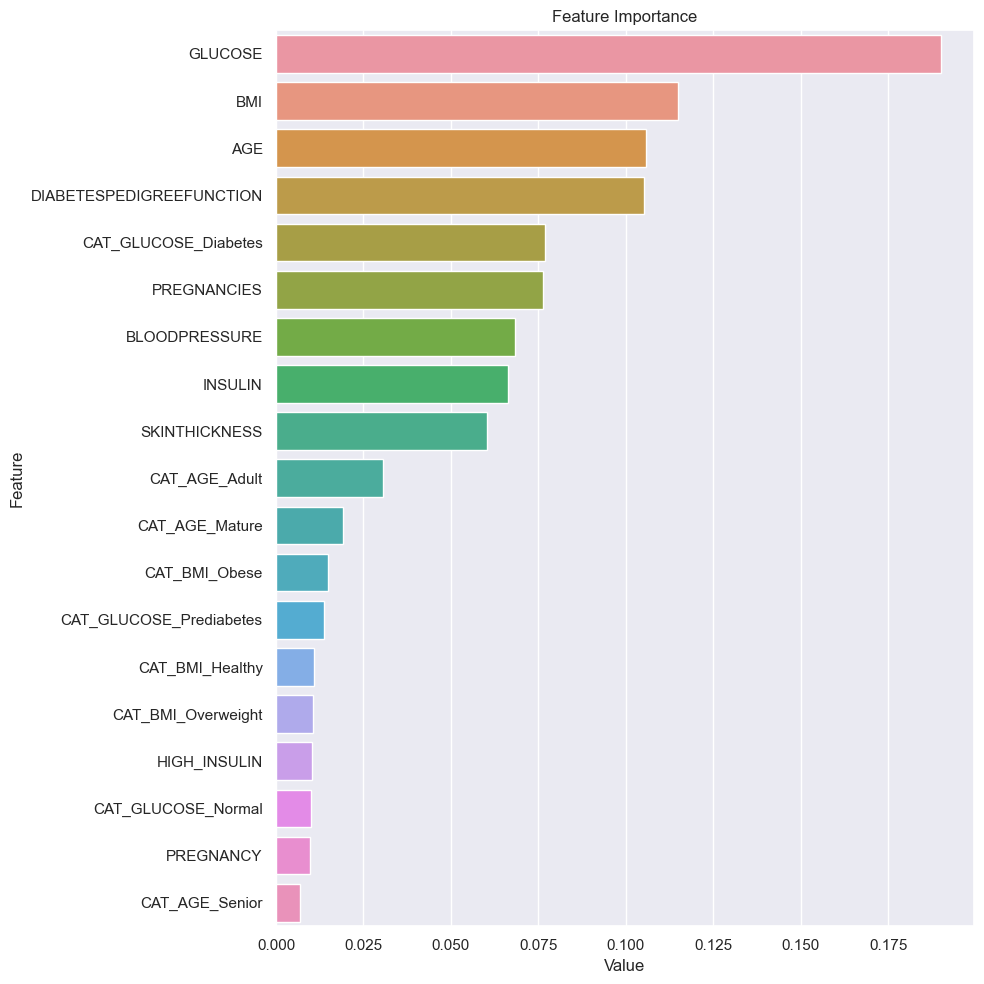

In [69]:
def plot_importance(model, features, num=len(X)):
    
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show(block=True)

plot_importance(rf_model, X)

Text(47.25, 0.5, 'Predicted')

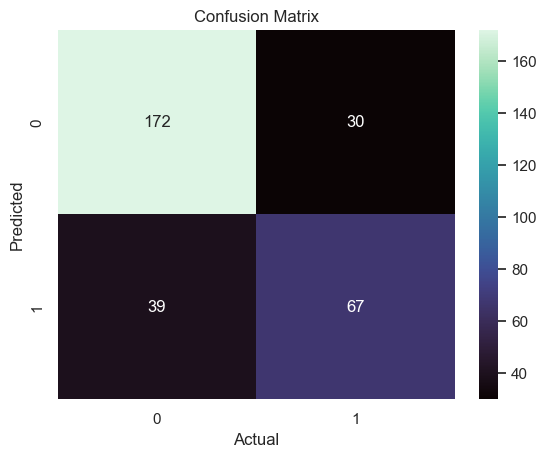

In [70]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
g = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="mako" ,fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")